In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise as pw
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from scipy import sparse
import ast

import warnings
warnings.filterwarnings('ignore')

In [1]:
df_genome_score = pd.read_csv('genome-scores.csv')
df_genome_score.head()

In [27]:
# df_genome_tags = pd.read_csv('genome-tags.csv')
# df_genome_tags.head()

In [28]:
# df_links = pd.read_csv('links.csv')
# df_links.head()

In [29]:
df_movies = pd.read_csv('movies.csv')
df_movies_copy = df_movies.copy()
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [30]:
df_movies.shape

(27278, 3)

In [31]:
print('Number of movies: ',len(df_movies['movieId'].value_counts()))

Number of movies:  27278


### Visualization to find if there were any words which used to repeat in most of the movies

In [32]:
# Create a wordcloud of the movie titles
df_movies['title'] = df_movies['title'].fillna("").astype('str')
title_corpus = ' '.join(df_movies['title'])

In [33]:
len(title_corpus)

787835

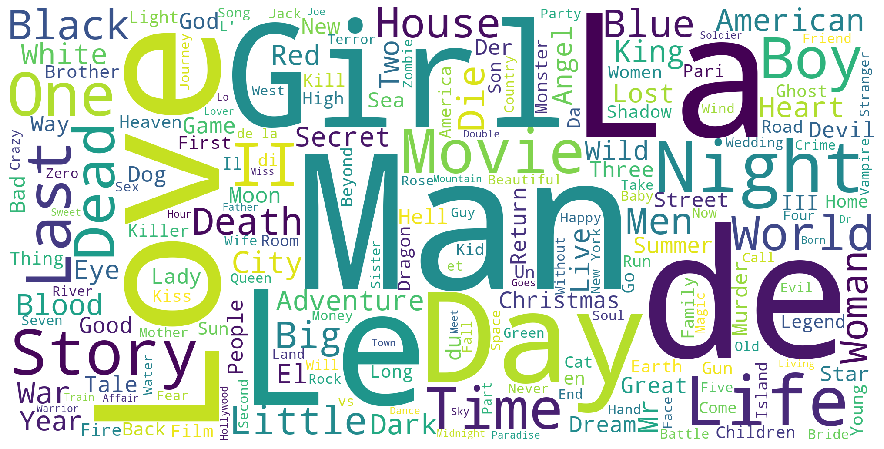

In [34]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=1000, width=2000).generate(title_corpus)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [35]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [36]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [37]:
# Checking for duplicated movieIDs
display(df_movies['movieId'].value_counts().sort_values(ascending=False).head()) 


131072    1
120891    1
116793    1
59421     1
2049      1
Name: movieId, dtype: int64

In [40]:
# Checking for duplicated titles
display(df_movies['title'].value_counts().sort_values(ascending=False).head(10) > 1)



Aladdin (1992)              True
Men with Guns (1997)        True
Clear History (2013)        True
Casanova (2005)             True
Emma (1996)                 True
Beneath (2013)              True
Johnny Express (2014)       True
War of the Worlds (2005)    True
Offside (2006)              True
Blackout (2007)             True
Name: title, dtype: bool

In [41]:
# Extracting duplicated movie ids
duplicate_movies = df_movies.groupby('title').filter(lambda x: len(x) == 2)
duplic_ids = duplicate_movies['movieId'].values
#Duplicated titles
duplicate_movies = duplicate_movies[['movieId','title']]
# Checking the id with most reviews
review_count = pd.DataFrame(df_ratings[df_ratings['movieId'].isin(duplic_ids)]['movieId'].value_counts())
review_count.reset_index(inplace=True)
review_count.columns = ['movieId','count']
duplicated_df = pd.merge(duplicate_movies, review_count, on='movieId')
display(duplicated_df)
## Getting duplicates with low review count
duplicated_df.sort_values(by=['title','count'],ascending=[True,False])
duplicated_ids = duplicated_df.drop_duplicates(subset ="title", 
                     keep = 'last', inplace = False)['movieId']


,movieId,title,count
0,588,Aladdin (1992),41842
1,838,Emma (1996),7938
2,1788,Men with Guns (1997),683
3,3598,Hamlet (2000),1168
4,26958,Emma (1996),19
5,26982,Men with Guns (1997),32
6,34048,War of the Worlds (2005),6456
7,42015,Casanova (2005),578
8,47254,Chaos (2005),244
9,48682,Offside (2006),88


In [43]:
# Removing duplicated ids with low review count from movie database
df_movies = df_movies.loc[~df_movies['movieId'].isin(duplicated_ids)]
# Removing duplicated ids with low review count from rating database
df_ratings = df_ratings.loc[~df_ratings['movieId'].isin(duplicated_ids)]


In [47]:
display(df_movies['movieId'].value_counts().sort_values(ascending=False).head()) 



131072    1
120891    1
116793    1
59421     1
2049      1
Name: movieId, dtype: int64

In [48]:
display(df_movies['title'].value_counts().sort_values(ascending=False).head(10) > 1)



Moon in the Gutter, The (La lune dans le caniveau) (1983)    False
Hits (2014)                                                  False
Three Outlaw Samurai (Sanbiki no samurai) (1964)             False
Deadly Mantis, The (1957)                                    False
The Secret of Dr. Kildare (1939)                             False
Mongol (2007)                                                False
Kagemusha (1980)                                             False
Special Mission Lady Chaplin (1966)                          False
The Last Gladiators (2011)                                   False
Serious Man, A (2009)                                        False
Name: title, dtype: bool

In [49]:
print('Number of Users : ',len(df_ratings['userId'].value_counts()))

Number of Users :  138493


In [10]:
df_ratings.drop('timestamp', axis=1,inplace= True)

In [11]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [12]:
len(df_ratings['userId'].value_counts())

138493

In [13]:
max_no_rows = (int)(1e7)
df_sample = df_ratings[1:max_no_rows]

In [14]:
df_merge = pd.merge(df_ratings, df_movies, on='movieId')
df_merge.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [22]:
len(df_merge['movieId'].value_counts())

1064

In [17]:
max_no_rows = (int)(1e7)
df_merge = df_ratings[1:max_no_rows]

In [18]:
len(df_sample['userId'].value_counts())

69139

In [44]:
pivot_item_based = pd.pivot_table(df_sample,index='title',columns=['userId'], values='rating')

In [18]:
pivot_item_based.shape

(23304, 69139)

In [166]:
recommender_df.shape

(1063, 1063)

In [ ]:
sparse_pivot = sparse.csr_matrix(pivot_item_based.fillna(0))

In [23]:
sparse_pivot

<23304x69139 sparse matrix of type '<class 'numpy.float64'>'
	with 9999999 stored elements in Compressed Sparse Row format>

In [24]:
recommender = pw.cosine_similarity(sparse_pivot)

In [32]:
recommender_df = pd.DataFrame(recommender,columns=pivot_item_based.index,index=pivot_item_based.index)

In [33]:
recommender_df

movieId,1,2,3,4,5,6,7,8,9,10,...,131023,131027,131031,131162,131164,131166,131168,131231,131258,131260
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.403541,0.307756,0.117461,0.300156,0.382838,0.308374,0.105268,0.168350,0.381921,...,0.006323,0.007904,0.004742,0.0,0.006323,0.006323,0.007113,0.000000,0.004742,0.006323
2,0.403541,1.000000,0.234371,0.161704,0.257327,0.280325,0.231632,0.193051,0.141246,0.425307,...,0.000000,0.005684,0.000000,0.0,0.011369,0.011369,0.008527,0.009948,0.008527,0.008527
3,0.307756,0.234371,1.000000,0.164064,0.454160,0.281109,0.390936,0.144859,0.250417,0.200877,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.117461,0.161704,0.164064,1.000000,0.191645,0.112785,0.184937,0.148690,0.114956,0.125567,...,0.000000,0.000000,0.000000,0.0,0.035077,0.035077,0.000000,0.000000,0.000000,0.000000
5,0.300156,0.257327,0.454160,0.191645,1.000000,0.242312,0.403702,0.157093,0.235623,0.200526,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.382838,0.280325,0.281109,0.112785,0.242312,1.000000,0.267241,0.060432,0.240999,0.383652,...,0.000000,0.008127,0.000000,0.0,0.000000,0.000000,0.009288,0.000000,0.011610,0.009288
7,0.308374,0.231632,0.390936,0.184937,0.403702,0.267241,1.000000,0.126933,0.202671,0.212958,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.014219,0.014219,0.000000,0.000000
8,0.105268,0.193051,0.144859,0.148690,0.157093,0.060432,0.126933,1.000000,0.089739,0.111212,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.168350,0.141246,0.250417,0.114956,0.235623,0.240999,0.202671,0.089739,1.000000,0.163147,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
recommender_df

In [34]:
recommender_df.shape

(23304, 23304)

In [37]:
def item_based_recom(film_name): 
    # Item Rating Based Cosine Similarity
    cosine_df = pd.DataFrame(recommender_df[film_name].sort_values(ascending=False))
    cosine_df.reset_index(level=0, inplace=True)
    cosine_df.columns = ['movieId','cosine_sim']
    return cosine_df

#Sending the Movie ID
a = item_based_recom(1).head(10)

In [40]:
a

,movieId,cosine_sim
0,1,1.000000
1,260,0.575919
2,780,0.564741
3,1210,0.552680
4,3114,0.544031
5,1270,0.543125
6,356,0.536838
7,588,0.534616
8,648,0.530338
9,480,0.529964


In [38]:
movie_recommendation = pd.merge(a,df_movies_copy,on='movieId')

In [39]:
movie_recommendation

,movieId,cosine_sim,title,genres
0,1,1.000000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,260,0.575919,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
2,780,0.564741,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
3,1210,0.552680,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
4,3114,0.544031,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
5,1270,0.543125,Back to the Future (1985),Adventure|Comedy|Sci-Fi
6,356,0.536838,Forrest Gump (1994),Comedy|Drama|Romance|War
7,588,0.534616,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
8,648,0.530338,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
9,480,0.529964,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


In [23]:
df_merge = pd.merge(df_ratings, df_movies, on='movieId')
df_merge.head()

,userId,movieId,rating,title
0,1,2,3.5,Jumanji (1995)
1,5,2,3.0,Jumanji (1995)
2,13,2,3.0,Jumanji (1995)
3,29,2,3.0,Jumanji (1995)
4,34,2,3.0,Jumanji (1995)


In [27]:
df_merge.shape

(20000263, 4)

In [25]:
max_no_rows = (int)(1e7)
df_sample = df_merge[1:max_no_rows]

In [26]:
pivot_item_based = pd.pivot_table(df_sample,index='title',columns=['userId'], values='rating')

In [28]:
pivot_item_based

userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
title,,,,,,,,,,,,,,,,,,,,,
*batteries not included (1987),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"10,000 BC (2008)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100 Girls (2000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
102 Dalmatians (2000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13 Ghosts (1960),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13 Going on 30 (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1408 (2007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
sparse_pivot = sparse.csr_matrix(pivot_item_based.fillna(0))


In [30]:
sparse_pivot

<1063x138483 sparse matrix of type '<class 'numpy.float64'>'
	with 9999719 stored elements in Compressed Sparse Row format>

In [31]:
recommender = pw.cosine_similarity(sparse_pivot)

In [32]:
recommender_df = pd.DataFrame(recommender,columns=pivot_item_based.index,index=pivot_item_based.index)

In [33]:
recommender_df

title,*batteries not included (1987),10 Things I Hate About You (1999),"10,000 BC (2008)",100 Girls (2000),101 Dalmatians (1996),102 Dalmatians (2000),13 Ghosts (1960),13 Going on 30 (2004),1408 (2007),16 Blocks (2006),...,X-Men (2000),X-Men Origins: Wolverine (2009),X-Men: The Last Stand (2006),X2: X-Men United (2003),Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),eXistenZ (1999),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
*batteries not included (1987),1.000000,0.143791,0.121833,0.067783,0.116362,0.083252,0.154779,0.139077,0.125606,0.119500,...,0.132671,0.097774,0.125555,0.149326,0.072829,0.055236,0.092339,0.101116,0.091087,0.121395
10 Things I Hate About You (1999),0.143791,1.000000,0.127768,0.099528,0.228837,0.153283,0.109650,0.302732,0.154524,0.132902,...,0.297529,0.124295,0.191931,0.245357,0.104639,0.068141,0.310000,0.160212,0.148254,0.180416
"10,000 BC (2008)",0.121833,0.127768,1.000000,0.106375,0.113276,0.101935,0.132695,0.135846,0.201227,0.201333,...,0.127091,0.221996,0.190918,0.139589,0.022324,0.030336,0.068380,0.039809,0.059631,0.054478
100 Girls (2000),0.067783,0.099528,0.106375,1.000000,0.050262,0.039828,0.068605,0.106630,0.097001,0.095035,...,0.052613,0.076777,0.070474,0.054226,0.012685,0.015702,0.045087,0.022056,0.029862,0.029652
101 Dalmatians (1996),0.116362,0.228837,0.113276,0.050262,1.000000,0.258986,0.095903,0.197682,0.113784,0.094259,...,0.168289,0.101501,0.141338,0.159857,0.092920,0.054416,0.207243,0.152323,0.072556,0.133405
102 Dalmatians (2000),0.083252,0.153283,0.101935,0.039828,0.258986,1.000000,0.106346,0.178343,0.082806,0.063384,...,0.098434,0.076758,0.082324,0.090680,0.055220,0.023559,0.103619,0.059171,0.039471,0.061943
13 Ghosts (1960),0.154779,0.109650,0.132695,0.068605,0.095903,0.106346,1.000000,0.140686,0.171190,0.104861,...,0.068068,0.050884,0.064451,0.067262,0.038031,0.027380,0.041587,0.049126,0.044765,0.041443
13 Going on 30 (2004),0.139077,0.302732,0.135846,0.106630,0.197682,0.178343,0.140686,1.000000,0.180498,0.157093,...,0.159658,0.132914,0.171832,0.176674,0.053272,0.034907,0.199091,0.085900,0.071269,0.093609
1408 (2007),0.125606,0.154524,0.201227,0.097001,0.113784,0.082806,0.171190,0.180498,1.000000,0.261943,...,0.154323,0.199505,0.213881,0.167681,0.047231,0.052331,0.098005,0.076667,0.116479,0.072882


In [21]:
recommender_df.shape

(1063, 1063)

In [42]:
def movie_based_recom(film_name):    
    # Movie Rating Based Cosine Similarity
    cosine_df = pd.DataFrame(recommender_df[film_name].sort_values(ascending=False))
    cosine_df.reset_index(level=0, inplace=True)
    cosine_df.columns = ['title','cosine_sim']
    return cosine_df


In [43]:
movie_based_recom('Mission: Impossible (1996)')

,title,cosine_sim
0,Mission: Impossible (1996),1.000000
1,Independence Day (a.k.a. ID4) (1996),0.657898
2,"Rock, The (1996)",0.633757
3,Twister (1996),0.616771
4,Jurassic Park (1993),0.533644
5,Speed (1994),0.533226
6,Toy Story (1995),0.532355
7,Star Wars: Episode IV - A New Hope (1977),0.525249
8,Broken Arrow (1996),0.521201
9,Eraser (1996),0.514163


In [41]:
# Break up the big genre string into a string array
df_movies_copy['genres'] = df_movies_copy['genres'].str.split('|')

In [42]:
df_movies_copy.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [85]:
df_genre = pd.read_csv('movies.csv')

In [88]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count
#here we  make census of the genres:
genre_labels = set()
for s in df_genre['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))


In [90]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(df_genre, 'genres', genre_labels)
keyword_occurences


[['Drama', 13344],
 ['Comedy', 8374],
 ['Thriller', 4178],
 ['Romance', 4127],
 ['Action', 3520],
 ['Crime', 2939],
 ['Horror', 2611],
 ['Documentary', 2471],
 ['Adventure', 2329],
 ['Sci-Fi', 1743],
 ['Mystery', 1514],
 ['Fantasy', 1412],
 ['War', 1194],
 ['Children', 1139],
 ['Musical', 1036],
 ['Animation', 1027],
 ['Western', 676],
 ['Film-Noir', 330],
 ['(no genres listed)', 246],
 ['IMAX', 196]]

In [97]:
keyword_occurences = pd.DataFrame(keyword_occurences)

In [98]:
keyword_occurences

,0,1
0,Drama,13344
1,Comedy,8374
2,Thriller,4178
3,Romance,4127
4,Action,3520
5,Crime,2939
6,Horror,2611
7,Documentary,2471
8,Adventure,2329
9,Sci-Fi,1743


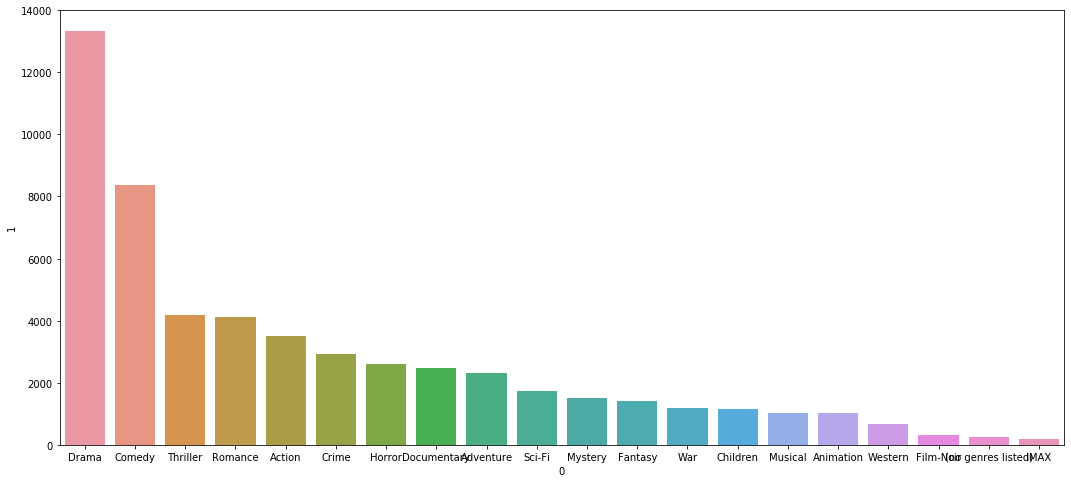

In [114]:
import seaborn as sns
plt.figure(figsize=(18,8))
sns.barplot(x=0, y=1, data=keyword_occurences)
plt.show()


In [43]:
# Convert genres to string value
df_movies_copy['genres'] = df_movies_copy['genres'].fillna(" ").astype('str')

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_movies_copy['genres'])
tfidf_matrix.shape


(27278, 189)

In [46]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]


array([[1.        , 0.3170459 , 0.06282188, 0.05665841],
       [0.3170459 , 1.        , 0.        , 0.        ],
       [0.06282188, 0.        , 1.        , 0.35995626],
       [0.05665841, 0.        , 0.35995626, 1.        ]])

In [59]:
# Build a 1-dimensional array with movie titles
titles = df_movies_copy['title']
indices = pd.Series(df_movies_copy.index, index=df_movies_copy['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [62]:
genre_recommendations('Toy Story (1995)').head(20)

2209                                           Antz (1998)
3027                                    Toy Story 2 (1999)
3663        Adventures of Rocky and Bullwinkle, The (2000)
3922                      Emperor's New Groove, The (2000)
4790                                 Monsters, Inc. (2001)
10114    DuckTales: The Movie - Treasure of the Lost La...
10987                                     Wild, The (2006)
11871                               Shrek the Third (2007)
13337                       Tale of Despereaux, The (2008)
18274    Asterix and the Vikings (Astérix et les Viking...
21355                                         Turbo (2013)
24092                                       Aladdin (1992)
24156                                Boxtrolls, The (2014)
24458            Toy Story Toons: Hawaiian Vacation (2011)
24460                    Toy Story Toons: Small Fry (2011)
24849                             The Magic Crystal (2011)
27270                                Brother Bear 2 (200

In [63]:
genre_recommendations('Good Will Hunting (1997)').head(20)

24                            Leaving Las Vegas (1995)
27                                   Persuasion (1995)
34                                   Carrington (1995)
45                How to Make an American Quilt (1995)
48                        When Night Is Falling (1995)
73                                 Bed of Roses (1996)
82     Once Upon a Time... When We Were Colored (1995)
84                           Angels and Insects (1995)
103              Bridges of Madison County, The (1995)
129                           Frankie Starlight (1995)
138                       Up Close and Personal (1996)
177                                    Mad Love (1995)
180                     Moonlight and Valentino (1995)
189                         Scarlet Letter, The (1995)
200                               Total Eclipse (1995)
205                       Walk in the Clouds, A (1995)
213                              Before Sunrise (1995)
219                           Circle of Friends (1995)
246       

In [118]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [157]:
df_movies = pd.read_csv('movies.csv')

In [158]:
new= df_movies["title"].str.split("(", n = 1, expand = True) 


In [159]:
df_movies["title"]= new[0] 
df_movies["year"]= new[1] 

In [160]:
df_movies['year'] = df_movies['year'].str.replace(')','')

In [163]:
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
